<a href="https://colab.research.google.com/github/vinivel/meuRepositorio/blob/main/C%C3%B3pia_de_CE_6_1_principiante_por.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estudo de táxi 6.1 - Corridas de táxi em Nova York

#### Observação: Se em algum momento este notebook for encerrado, você terá que executar novamente todas as células ao reabri-lo.

#### Observação: É possível que haja diferentes resultados numéricos se o notebook for executado em diferentes ocasiões. Isto é normal. Simplesmente entregue os resultados obtidos.

# PYTHON PARA INICIANTES

Visto que esta é a versão para iniciantes, incluímos a maior parte do código para ajudá-lo no estudo.

**Primeiro, preencha suas informações de contato na célula abaixo. Depois, basta anotar as respostas às perguntas que forem feitas. Para o resto das células, basta executá-las selecionando o botão Run na parte superior do notebook**


# Informação de contato

In [ ]:
# SEU NOME                = Vinicius Veloso    
# SEU USUÁRIO MITX PRO    = Vinicius Veloso
# SEU E-MAIL MITX PRO     = vinivel@live.com

# Configuração

Execute (Run) estas células para instalar os pacotes necessários para a realização do estudo de caso. Tenha paciência, pois isso poderá levar alguns minutos.

<h1 style="color:red;">ATENÇÃO: Podem ocorrer erros ao executar as células abaixo. Mas não se preocupe. É só executar a célula de importação de bibliotecas (duas mais abaixo) e, se aparecer a mensagem "Bibliotecas importadas com sucesso", você pode prosseguir com o estudo de caso.<h1>

In [1]:
!pip uninstall -y folium
!pip install -q folium==0.2.1
!pip uninstall -y urllib3
!pip install -q urllib3==1.25.4

Found existing installation: folium 0.8.3
Uninstalling folium-0.8.3:
  Successfully uninstalled folium-0.8.3
     |████████████████████████████████| 69 kB 2.0 MB/s 
Found existing installation: urllib3 1.24.3
Uninstalling urllib3-1.24.3:
  Successfully uninstalled urllib3-1.24.3
     |████████████████████████████████| 125 kB 5.3 MB/s 


In [2]:
!pip install -q --upgrade pip
!pip uninstall -y featuretools
#!pip install -q featuretools~=0.23.0
!pip install -q featuretools~=0.1.14
!pip uninstall -y pandas
!pip install -q pandas~=1.1.0
print('Bibliotecas instaladas com sucesso!!')

     |████████████████████████████████| 1.7 MB 4.9 MB/s 
     |████████████████████████████████| 140 kB 5.0 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 164 kB 38.1 MB/s            
     |████████████████████████████████| 54 kB 1.2 MB/s             
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 133 kB 52.8 MB/s            
     |████████████████████████████████| 1.1 MB 28.3 MB/s            
     |████████████████████████████████| 8.4 MB 34.7 MB/s            
     |████████████████████████████████| 144 kB 29.7 MB/s            
     |████████████████████████████████| 94 kB 1.4 MB/s             
     |████████████████████████████████| 271 kB 49.6 MB/s            
Found existing installation: pandas 1.1.5
Uninstalling pandas-1.1.5:
  Successfully uninstalled pandas-1.1.5
     |████████████████████████████████| 9.5 MB 5.0 MB/s            
Bibliotecas instaladas com sucesso!!


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Se nenhum texto em vermelho indicando erro aparecer, isso significa que a instalação foi bem-sucedida. Os textos em amarelo são avisos, mas não erros.

<h1>Atenção:</h1>

Agora, reinicie o ambiente de execução. Para isso, vá para:

> Ambiente de execução > _Reiniciar ambiente de execução_ 

na parte superior da tela. Isto irá garantir que suas alterações foram feitas com sucesso.


# Importar

Sincronize sua conta do Google. Para isso, siga o link que aparece na saída da seguinte célula uma vez executada. Copie o código que aparece na tela e insira-o na saída da célula. Assim que visualizar a mensagem: `Google Drive sincronizado com sucesso!`poderá continuar executando o restante das células.

In [1]:
from google.colab import auth
auth.authenticate_user()

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
data_drop = drive.CreateFile({'id':'10aXz56ohVOgF2gH4yvmrvTJFY990RHZ1'})
data_drop.GetContentFile('dropoff_neighborhoods.csv')
data_pick = drive.CreateFile({'id':'1zakjpcMUZTKanSeVlPWbYhL85zn5g8zX'})
data_pick.GetContentFile('pickup_neighborhoods.csv')
data_trips = drive.CreateFile({'id':'1D4OJPulDK-Z5l4mgwuI2C1zBr4JRC-Q5'})
data_trips.GetContentFile('trips.pkl')
utils_file = drive.CreateFile({'id':'1UbV2z7L5vonCz3KFLywGs4U-p2g5gQwy'})
utils_file.GetContentFile('utils.py')

print('Google Drive sincronizado com sucesso!')

Google Drive sincronizado com sucesso!


Importe as bibliotecas necessárias para o desenvolvimento do estudo de caso.

In [2]:
import featuretools as ft
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils
from featuretools.primitives import (Count, Day, Hour, Max, Mean, Median, Min,
                                     Minute, Month, Std, Sum, Week, Weekday,
                                     Weekend as Weekend)
from sklearn.ensemble import GradientBoostingRegressor
from utils import (compute_features, feature_importances, load_nyc_taxi_data,
                   preview)
%matplotlib inline

print('Bibliotecas importadas com suceso!')

Bibliotecas importadas com suceso!


In [3]:
# assert ft.__version__ == '0.1.19', 'Certifique-se de ter executado o comando anterior com a versão correta.'
# assert pd.__version__ == '0.20.3', 'Certifique-se de ter executado o comando anterior com a versão correta.'
# print('Versão correta das bibliotecas chave!!')

# Dados

Carregue o banco de dados de corridas de táxi em Nova York. Tenha paciência, pois isso poderá levar alguns minutos.

In [29]:
trips, pickup_neighborhoods, dropoff_neighborhoods = load_nyc_taxi_data()
preview(trips, 5)
#print('Dados carregados com sucesso!')

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
0,514030,2,2016-04-02 00:00:00,2016-04-02 00:17:00,1,2.46,-73.987595,40.754711,-73.959633,40.762836,1,1039,AA,K
1,514031,1,2016-04-02 00:00:00,2016-04-02 00:24:00,2,7.90,-73.924713,40.745567,-73.972763,40.793354,1,1454,L,U
2,514032,1,2016-04-02 00:00:00,2016-04-02 00:19:00,1,1.00,-73.989800,40.732994,-74.000557,40.742622,1,1168,H,Q
3,514033,2,2016-04-02 00:00:00,2016-04-02 00:01:00,1,0.02,-73.987465,40.719822,-73.987289,40.720016,2,35,AC,AC
4,514034,1,2016-04-02 00:01:00,2016-04-02 00:58:00,2,19.00,-73.790131,40.643429,-73.975594,40.779327,1,3470,G,I


Também podemos gerar alguns gráficos sobre alguns aspectos dos dados para ter uma ideia melhor de suas distribuições. Por exemplo, aqui é exibida a variável `trip_duration` (duração da corrida), a qual tentaremos prever.

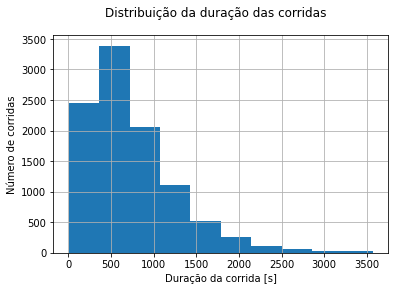

Histograma gerado com sucesso!


In [5]:
trips.trip_duration.hist()
plt.xlabel('Duração da corrida [s]')
plt.ylabel('Número de corridas')
plt.suptitle('Distribuição da duração das corridas')
plt.show()
print('Histograma gerado com sucesso!')

In [6]:
trips.shape[0]  # Mostra quantas corridas existem no banco de dados

10000

In [7]:
trips.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
0,514030,2,2016-04-02 00:00:00,2016-04-02 00:17:00,1,2.46,-73.987595,40.754711,-73.959633,40.762836,1,1039,AA,K
1,514031,1,2016-04-02 00:00:00,2016-04-02 00:24:00,2,7.90,-73.924713,40.745567,-73.972763,40.793354,1,1454,L,U
2,514032,1,2016-04-02 00:00:00,2016-04-02 00:19:00,1,1.00,-73.989800,40.732994,-74.000557,40.742622,1,1168,H,Q
3,514033,2,2016-04-02 00:00:00,2016-04-02 00:01:00,1,0.02,-73.987465,40.719822,-73.987289,40.720016,2,35,AC,AC
4,514034,1,2016-04-02 00:01:00,2016-04-02 00:58:00,2,19.00,-73.790131,40.643429,-73.975594,40.779327,1,3470,G,I


<h1>PERGUNTA 1: ANÁLISE DE DADOS</h1>

**Descreva o banco de dados. Quantas corridas existem no banco de dados? Como você descreveria a distribuição da duração das corridas? Há algo mais que devemos observar? Certifique-se de que o histograma esteja visível no *notebook***.



No banco de dados há 10000 corridas.

# Entidades e relações

In [8]:
entities = {
    "trips": (trips, "id", 'pickup_datetime'),
    "pickup_neighborhoods": (pickup_neighborhoods, "neighborhood_id"),
    "dropoff_neighborhoods": (dropoff_neighborhoods, "neighborhood_id"),
}

relationships = [("pickup_neighborhoods", "neighborhood_id", "trips", "pickup_neighborhood"),
                 ("dropoff_neighborhoods", "neighborhood_id", "trips", "dropoff_neighborhood")]

print('Entidades e relações configuradas com sucesso!')

Entidades e relações configuradas com sucesso!


# Primitivas de transformação

In [9]:
trans_primitives = [Weekend]

# Tenha paciência, pois isso poderá levar alguns minutos
features = ft.dfs(entities =entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude", "trip_duration"]},
                  features_only=True)

print('Primitivas de transformação configuradas com sucesso!')

Primitivas de transformação configuradas com sucesso!


Aqui estão algumas *features* que acabamos de criar:

In [10]:
print(f"Número de features: {len(features)}")
features

Número de features: 12


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: WEEKEND(pickup_datetime)>,
 <Feature: WEEKEND(dropoff_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>]

Por fim, calculamos a matriz de *features* com as *features* mencionadas antes:

In [11]:
feature_matrix = compute_features(features, entities, relationships)
preview(feature_matrix, 5)

Elapsed: 00:03 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 10/10 chunks
Finishing computing...


,trip_distance,pickup_neighborhood = AA,pickup_neighborhood = D,pickup_neighborhood = AC,pickup_neighborhood = AB,pickup_neighborhood = AO,pickup_neighborhood = AD,pickup_neighborhood = Q,pickup_neighborhood = AR,pickup_neighborhood = AP,pickup_neighborhood = H,pickup_neighborhood = R,pickup_neighborhood = AT,pickup_neighborhood = A,pickup_neighborhood = X,pickup_neighborhood = C,pickup_neighborhood = AK,pickup_neighborhood = N,pickup_neighborhood = AM,pickup_neighborhood = Y,pickup_neighborhood = I,pickup_neighborhood = AV,pickup_neighborhood = P,pickup_neighborhood = O,pickup_neighborhood = K,pickup_neighborhood = AU,pickup_neighborhood = U,pickup_neighborhood = G,pickup_neighborhood = AG,pickup_neighborhood = F,pickup_neighborhood = AH,pickup_neighborhood = Z,pickup_neighborhood = J,pickup_neighborhood = AS,pickup_neighborhood = AL,pickup_neighborhood = L,pickup_neighborhood = V,pickup_neighborhood = W,pickup_neighborhood = AN,pickup_neighborhood = AJ,...,dropoff_neighborhood = Y,dropoff_neighborhood = N,dropoff_neighborhood = K,dropoff_neighborhood = C,dropoff_neighborhood = Q,dropoff_neighborhood = I,dropoff_neighborhood = O,dropoff_neighborhood = R,dropoff_neighborhood = AC,dropoff_neighborhood = AK,dropoff_neighborhood = AM,dropoff_neighborhood = AU,dropoff_neighborhood = AT,dropoff_neighborhood = U,dropoff_neighborhood = AG,dropoff_neighborhood = Z,dropoff_neighborhood = AH,dropoff_neighborhood = J,dropoff_neighborhood = W,dropoff_neighborhood = AL,dropoff_neighborhood = AS,dropoff_neighborhood = F,dropoff_neighborhood = V,dropoff_neighborhood = G,dropoff_neighborhood = E,dropoff_neighborhood = S,dropoff_neighborhood = AW,dropoff_neighborhood = AN,dropoff_neighborhood = AJ,dropoff_neighborhood = L,dropoff_neighborhood = M,dropoff_neighborhood = AF,dropoff_neighborhood = T,dropoff_neighborhood = B,dropoff_neighborhood = AI,dropoff_neighborhood = AE,dropoff_neighborhood = AQ,pickup_neighborhoods.longitude,WEEKEND(dropoff_datetime),vendor_id
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
514030,2.46,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-73.986446,True,2
514031,7.90,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-73.919159,True,1
514032,1.00,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-73.991595,True,1
514033,0.02,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-73.987205,True,2
514034,19.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-73.785073,True,1


# Primeiro modelo

In [12]:
# Separação dos dados de treinamento e teste
X_train, y_train, X_test, y_test = utils.get_train_test_fm(feature_matrix, trips, .75)
y_train = np.log(y_train + 1)
y_test = np.log(y_test + 1)

print('Dados separados com sucesso!')

Dados separados com sucesso!


In [13]:
# O treinamento deve durar cerca de um minuto
model = GradientBoostingRegressor(verbose=True)
model.fit(X_train, y_train)
print(model.score(X_test, y_test)) # Valor R^2 da previsão

print('Fase de treinamento realizada com sucesso!')

      Iter       Train Loss   Remaining Time 
         1           0.4736            2.86s
         2           0.4148            2.46s
         3           0.3661            2.33s
         4           0.3266            2.25s
         5           0.2934            2.16s
         6           0.2665            2.15s
         7           0.2441            2.08s
         8           0.2257            2.05s
         9           0.2103            2.01s
        10           0.1973            2.00s
        20           0.1433            1.76s
        30           0.1308            1.49s
        40           0.1252            1.25s
        50           0.1212            1.04s
        60           0.1187            0.83s
        70           0.1167            0.67s
        80           0.1155            0.46s
        90           0.1143            0.24s
       100           0.1133            0.00s
0.7554602339195134
Fase de treinamento realizada com sucesso!


<h1 style="color:red;">PERGUNTA 2: PRIMEIRO MODELO</h1>

**Descreva todas as *features* que adicionamos ao modelo. Na sua opinião, elas melhoraram o desempenho em comparação a um modelo que não as possui? Por quê?**

*Escreva aqui sua resposta...*

# Mais primitivas de transformação

In [14]:
trans_primitives = [Minute, Hour, Day, Week, Month, Weekday, Weekend]

features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude", "trip_duration"]},
                  features_only=True)

print('Primitivas de tranformação configuradas com sucesso!')

Primitivas de tranformação configuradas com sucesso!


In [15]:
print(f"Número de features: {len(features)}")
features

Número de features: 24


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: MINUTE(pickup_datetime)>,
 <Feature: MINUTE(dropoff_datetime)>,
 <Feature: HOUR(pickup_datetime)>,
 <Feature: HOUR(dropoff_datetime)>,
 <Feature: DAY(pickup_datetime)>,
 <Feature: DAY(dropoff_datetime)>,
 <Feature: WEEK(pickup_datetime)>,
 <Feature: WEEK(dropoff_datetime)>,
 <Feature: MONTH(pickup_datetime)>,
 <Feature: MONTH(dropoff_datetime)>,
 <Feature: WEEKDAY(pickup_datetime)>,
 <Feature: WEEKDAY(dropoff_datetime)>,
 <Feature: WEEKEND(pickup_datetime)>,
 <Feature: WEEKEND(dropoff_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>]

In [16]:
feature_matrix = compute_features(features, entities, relationships)
preview(feature_matrix, 5)

Elapsed: 00:00 | Remaining: ? | Progress:   0%|          | Calculated: 0/10 chunks

/usr/local/lib/python3.7/dist-packages/featuretools/primitives/transform_primitive.py:529: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  return getattr(pd_index, time_unit).values


Elapsed: 00:00 | Remaining: 00:03 | Progress:  10%|█         | Calculated: 1/10 chunks

/usr/local/lib/python3.7/dist-packages/featuretools/primitives/transform_primitive.py:529: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  return getattr(pd_index, time_unit).values


Elapsed: 00:00 | Remaining: 00:02 | Progress:  20%|██        | Calculated: 2/10 chunks

/usr/local/lib/python3.7/dist-packages/featuretools/primitives/transform_primitive.py:529: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  return getattr(pd_index, time_unit).values


Elapsed: 00:01 | Remaining: 00:02 | Progress:  30%|███       | Calculated: 3/10 chunks

/usr/local/lib/python3.7/dist-packages/featuretools/primitives/transform_primitive.py:529: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  return getattr(pd_index, time_unit).values


Elapsed: 00:01 | Remaining: 00:02 | Progress:  40%|████      | Calculated: 4/10 chunks

/usr/local/lib/python3.7/dist-packages/featuretools/primitives/transform_primitive.py:529: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  return getattr(pd_index, time_unit).values


Elapsed: 00:01 | Remaining: 00:01 | Progress:  50%|█████     | Calculated: 5/10 chunks

/usr/local/lib/python3.7/dist-packages/featuretools/primitives/transform_primitive.py:529: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  return getattr(pd_index, time_unit).values


Elapsed: 00:02 | Remaining: 00:01 | Progress:  60%|██████    | Calculated: 6/10 chunks

/usr/local/lib/python3.7/dist-packages/featuretools/primitives/transform_primitive.py:529: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  return getattr(pd_index, time_unit).values


Elapsed: 00:02 | Remaining: 00:01 | Progress:  70%|███████   | Calculated: 7/10 chunks

/usr/local/lib/python3.7/dist-packages/featuretools/primitives/transform_primitive.py:529: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  return getattr(pd_index, time_unit).values


Elapsed: 00:02 | Remaining: 00:00 | Progress:  80%|████████  | Calculated: 8/10 chunks

/usr/local/lib/python3.7/dist-packages/featuretools/primitives/transform_primitive.py:529: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  return getattr(pd_index, time_unit).values


Elapsed: 00:03 | Remaining: 00:00 | Progress:  90%|█████████ | Calculated: 9/10 chunks

/usr/local/lib/python3.7/dist-packages/featuretools/primitives/transform_primitive.py:529: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  return getattr(pd_index, time_unit).values


Elapsed: 00:03 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 10/10 chunks
Finishing computing...


,pickup_neighborhood = AA,pickup_neighborhood = D,pickup_neighborhood = AC,pickup_neighborhood = AB,pickup_neighborhood = AO,pickup_neighborhood = AD,pickup_neighborhood = Q,pickup_neighborhood = AR,pickup_neighborhood = AP,pickup_neighborhood = H,pickup_neighborhood = R,pickup_neighborhood = AT,pickup_neighborhood = A,pickup_neighborhood = X,pickup_neighborhood = C,pickup_neighborhood = AK,pickup_neighborhood = N,pickup_neighborhood = AM,pickup_neighborhood = Y,pickup_neighborhood = I,pickup_neighborhood = AV,pickup_neighborhood = P,pickup_neighborhood = O,pickup_neighborhood = K,pickup_neighborhood = AU,pickup_neighborhood = U,pickup_neighborhood = G,pickup_neighborhood = AG,pickup_neighborhood = F,pickup_neighborhood = AH,pickup_neighborhood = Z,pickup_neighborhood = J,pickup_neighborhood = AS,pickup_neighborhood = AL,pickup_neighborhood = L,pickup_neighborhood = V,pickup_neighborhood = W,pickup_neighborhood = AN,pickup_neighborhood = AJ,pickup_neighborhood = E,...,dropoff_neighborhood = J,dropoff_neighborhood = W,dropoff_neighborhood = AL,dropoff_neighborhood = AS,dropoff_neighborhood = F,dropoff_neighborhood = V,dropoff_neighborhood = G,dropoff_neighborhood = E,dropoff_neighborhood = S,dropoff_neighborhood = AW,dropoff_neighborhood = AN,dropoff_neighborhood = AJ,dropoff_neighborhood = L,dropoff_neighborhood = M,dropoff_neighborhood = AF,dropoff_neighborhood = T,dropoff_neighborhood = B,dropoff_neighborhood = AI,dropoff_neighborhood = AE,dropoff_neighborhood = AQ,HOUR(dropoff_datetime),dropoff_neighborhoods.longitude,WEEKDAY(pickup_datetime),WEEK(dropoff_datetime),WEEKDAY(dropoff_datetime),WEEK(pickup_datetime),trip_distance,vendor_id,HOUR(pickup_datetime),payment_type,MONTH(dropoff_datetime),MINUTE(dropoff_datetime),MONTH(pickup_datetime),DAY(pickup_datetime),pickup_neighborhoods.longitude,passenger_count,WEEKEND(pickup_datetime),DAY(dropoff_datetime),MINUTE(pickup_datetime),pickup_neighborhoods.latitude
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
514030,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-73.956886,5,13,5,13,2.46,2,0,1,4,17,4,2,-73.986446,1,True,2,0,40.757707
514031,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-73.969822,5,13,5,13,7.90,1,0,1,4,24,4,2,-73.919159,2,True,2,0,40.744928
514032,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-74.005107,5,13,5,13,1.00,1,0,1,4,19,4,2,-73.991595,1,True,2,0,40.729652
514033,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-73.987205,5,13,5,13,0.02,2,0,2,4,1,4,2,-73.987205,1,True,2,0,40.720245
514034,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-73.976050,5,13,5,13,19.00,1,0,1,4,58,4,2,-73.785073,2,True,2,1,40.646194


In [17]:
# Separar novamente os dados
X_train, y_train, X_test, y_test = utils.get_train_test_fm(feature_matrix, trips, .75)
y_train = np.log(y_train + 1)
y_test = np.log(y_test + 1)

print('Dados separados com sucesso!')

Dados separados com sucesso!


In [18]:
# O treinamento deve durar cerca de um minuto
model = GradientBoostingRegressor(verbose=True)
model.fit(X_train, y_train)
print(model.score(X_test, y_test)) # Valor R^2 da previsão

print('Fase de treinamento realizada com sucesso!')

      Iter       Train Loss   Remaining Time 
         1           0.4736            4.74s
         2           0.4148            3.75s
         3           0.3661            3.43s
         4           0.3264            3.31s
         5           0.2930            3.20s
         6           0.2660            3.13s
         7           0.2432            3.08s
         8           0.2245            3.03s
         9           0.2090            2.98s
        10           0.1960            2.92s
        20           0.1362            2.45s
        30           0.1198            1.97s
        40           0.1124            1.72s
        50           0.1075            1.45s
        60           0.1044            1.15s
        70           0.1017            0.85s
        80           0.0999            0.56s
        90           0.0971            0.28s
       100           0.0936            0.00s
0.8012702948995593
Fase de treinamento realizada com sucesso!


<h1 style="color:red;">PERGUNTA 3: SEGUNDO MODELO</h1>

**Descreva o restante das novas *features* que acabamos de adicionar ao modelo. Como elas afetaram o desempenho? Foi preciso sacrificar um pouco do tempo de treinamento?**

*Escreva aqui sua resposta...*

# Primitivas de agregação

In [19]:
trans_primitives = [Minute, Hour, Day, Week, Month, Weekday, Weekend]
aggregation_primitives = [Count, Sum, Mean, Median, Std, Max, Min]

features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=aggregation_primitives,
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude", "trip_duration"]},
                  features_only=True)

print('Primitivas de agregação configuradas com sucesso!')

Primitivas de agregação configuradas com sucesso!


In [20]:
print(f"Número de features: {len(features)}")
features

Número de features: 62


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: MINUTE(pickup_datetime)>,
 <Feature: MINUTE(dropoff_datetime)>,
 <Feature: HOUR(pickup_datetime)>,
 <Feature: HOUR(dropoff_datetime)>,
 <Feature: DAY(pickup_datetime)>,
 <Feature: DAY(dropoff_datetime)>,
 <Feature: WEEK(pickup_datetime)>,
 <Feature: WEEK(dropoff_datetime)>,
 <Feature: MONTH(pickup_datetime)>,
 <Feature: MONTH(dropoff_datetime)>,
 <Feature: WEEKDAY(pickup_datetime)>,
 <Feature: WEEKDAY(dropoff_datetime)>,
 <Feature: WEEKEND(pickup_datetime)>,
 <Feature: WEEKEND(dropoff_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>,
 <Feature: pickup_neighborhoods.COUNT(trips)>,
 <Feature: pickup_neighborhoods.SUM(trips.vendor_id)>,
 <Feature: pickup_neighborhoods.SUM(t

In [21]:
# Isto pode levar certo tempo de computação, por isso tenha paciência
feature_matrix = compute_features(features, entities, relationships)
preview(feature_matrix, 5)

Elapsed: 00:00 | Remaining: ? | Progress:   0%|          | Calculated: 0/10 chunks

/usr/local/lib/python3.7/dist-packages/featuretools/primitives/transform_primitive.py:529: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  return getattr(pd_index, time_unit).values


Elapsed: 00:01 | Remaining: 00:10 | Progress:  10%|█         | Calculated: 1/10 chunks

/usr/local/lib/python3.7/dist-packages/featuretools/primitives/transform_primitive.py:529: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  return getattr(pd_index, time_unit).values


Elapsed: 00:02 | Remaining: 00:09 | Progress:  20%|██        | Calculated: 2/10 chunks

/usr/local/lib/python3.7/dist-packages/featuretools/primitives/transform_primitive.py:529: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  return getattr(pd_index, time_unit).values


Elapsed: 00:04 | Remaining: 00:06 | Progress:  40%|████      | Calculated: 4/10 chunks

/usr/local/lib/python3.7/dist-packages/featuretools/primitives/transform_primitive.py:529: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  return getattr(pd_index, time_unit).values


Elapsed: 00:05 | Remaining: 00:05 | Progress:  50%|█████     | Calculated: 5/10 chunks

/usr/local/lib/python3.7/dist-packages/featuretools/primitives/transform_primitive.py:529: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  return getattr(pd_index, time_unit).values
/usr/local/lib/python3.7/dist-packages/featuretools/primitives/transform_primitive.py:529: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  return getattr(pd_index, time_unit).values


Elapsed: 00:06 | Remaining: 00:04 | Progress:  60%|██████    | Calculated: 6/10 chunks

/usr/local/lib/python3.7/dist-packages/featuretools/primitives/transform_primitive.py:529: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  return getattr(pd_index, time_unit).values


Elapsed: 00:08 | Remaining: 00:02 | Progress:  80%|████████  | Calculated: 8/10 chunks

/usr/local/lib/python3.7/dist-packages/featuretools/primitives/transform_primitive.py:529: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  return getattr(pd_index, time_unit).values
/usr/local/lib/python3.7/dist-packages/featuretools/primitives/transform_primitive.py:529: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  return getattr(pd_index, time_unit).values


Elapsed: 00:11 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 10/10 chunks

/usr/local/lib/python3.7/dist-packages/featuretools/primitives/transform_primitive.py:529: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  return getattr(pd_index, time_unit).values



Finishing computing...


,pickup_neighborhoods.STD(trips.vendor_id),dropoff_neighborhoods.MEAN(trips.passenger_count),dropoff_neighborhoods.STD(trips.trip_distance),dropoff_neighborhoods.MAX(trips.passenger_count),payment_type,WEEKEND(dropoff_datetime),pickup_neighborhoods.STD(trips.passenger_count),dropoff_neighborhood = D,dropoff_neighborhood = AA,dropoff_neighborhood = H,dropoff_neighborhood = P,dropoff_neighborhood = AR,dropoff_neighborhood = AD,dropoff_neighborhood = A,dropoff_neighborhood = AB,dropoff_neighborhood = AV,dropoff_neighborhood = AP,dropoff_neighborhood = X,dropoff_neighborhood = AO,dropoff_neighborhood = Y,dropoff_neighborhood = N,dropoff_neighborhood = K,dropoff_neighborhood = C,dropoff_neighborhood = Q,dropoff_neighborhood = I,dropoff_neighborhood = O,dropoff_neighborhood = R,dropoff_neighborhood = AC,dropoff_neighborhood = AK,dropoff_neighborhood = AM,dropoff_neighborhood = AU,dropoff_neighborhood = AT,dropoff_neighborhood = U,dropoff_neighborhood = AG,dropoff_neighborhood = Z,dropoff_neighborhood = AH,dropoff_neighborhood = J,dropoff_neighborhood = W,dropoff_neighborhood = AL,dropoff_neighborhood = AS,...,pickup_neighborhoods.longitude,MINUTE(pickup_datetime),dropoff_neighborhoods.MEAN(trips.trip_distance),pickup_neighborhoods.MIN(trips.vendor_id),dropoff_neighborhoods.SUM(trips.vendor_id),pickup_neighborhoods.MIN(trips.trip_distance),pickup_neighborhoods.MEDIAN(trips.vendor_id),dropoff_neighborhoods.latitude,pickup_neighborhoods.MEDIAN(trips.passenger_count),dropoff_neighborhoods.MIN(trips.vendor_id),dropoff_neighborhoods.longitude,trip_distance,pickup_neighborhoods.SUM(trips.passenger_count),dropoff_neighborhoods.MEDIAN(trips.passenger_count),pickup_neighborhoods.MEDIAN(trips.trip_distance),dropoff_neighborhoods.SUM(trips.trip_distance),vendor_id,WEEK(dropoff_datetime),dropoff_neighborhoods.STD(trips.vendor_id),DAY(dropoff_datetime),pickup_neighborhoods.MEAN(trips.trip_distance),pickup_neighborhoods.MIN(trips.passenger_count),pickup_neighborhoods.MAX(trips.passenger_count),pickup_neighborhoods.MAX(trips.trip_distance),HOUR(pickup_datetime),WEEK(pickup_datetime),dropoff_neighborhoods.COUNT(trips),MONTH(pickup_datetime),WEEKEND(pickup_datetime),DAY(pickup_datetime),pickup_neighborhoods.STD(trips.trip_distance),pickup_neighborhoods.latitude,pickup_neighborhoods.COUNT(trips),MONTH(dropoff_datetime),WEEKDAY(pickup_datetime),pickup_neighborhoods.MAX(trips.vendor_id),pickup_neighborhoods.SUM(trips.vendor_id),dropoff_neighborhoods.MIN(trips.trip_distance),dropoff_neighborhoods.MIN(trips.passenger_count),passenger_count
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
514030,0.499980,1.735593,2.083190,6.0,1,True,1.220735,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,-73.986446,0,2.044915,1.0,464.0,0.0,2.0,40.766809,1.0,1.0,-73.956886,2.46,737.0,1.0,1.645,603.25,2,13,0.494660,2,2.930360,1.0,6.0,18.89,0,13,295.0,4,True,2,3.368966,40.757707,444.0,4,5,2.0,668.0,0.00,1.0,1
514031,0.495728,1.618785,2.735250,6.0,1,True,1.336028,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,-73.919159,0,2.451602,1.0,285.0,0.0,1.0,40.793597,1.0,1.0,-73.969822,7.90,77.0,1.0,2.800,443.74,1,13,0.494406,2,3.107391,1.0,6.0,16.40,0,13,181.0,4,True,2,2.757987,40.744928,46.0,4,5,2.0,66.0,0.30,1.0,2
514032,0.497628,1.723549,1.703662,6.0,1,True,1.335693,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,-73.991595,0,1.899113,1.0,445.0,0.1,2.0,40.740333,1.0,1.0,-74.005107,1.00,650.0,1.0,1.590,556.44,1,13,0.499648,2,2.366243,1.0,6.0,17.90,0,13,293.0,4,True,2,2.316361,40.729652,370.0,4,5,2.0,573.0,0.00,1.0,1
514033,0.499660,1.741135,2.740489,6.0,2,True,1.222417,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,-73.987205,0,2.532340,1.0,426.0,0.0,1.0,40.720245,1.0,1.0,-73.987205,0.02,666.0,1.0,2.500,714.12,2,13,0.499887,2,3.037617,1.0,6.0,17.38,0,13,282.0,4,True,2,2.428094,40.720245,407.0,4,5,2.0,603.0,0.00,1.0,1
514034,0.484539,1.645051,2.660020,6.0,1,Tr

In [22]:
# Separar novamente os dados
X_train, y_train, X_test, y_test = utils.get_train_test_fm(feature_matrix, trips, .75)
y_train = np.log(y_train + 1)
y_test = np.log(y_test + 1)

print('Dados separados com sucesso!')

Dados separados com sucesso!


In [23]:
# O treinamento deve durar cerca de um minuto
model = GradientBoostingRegressor(verbose=True)
model.fit(X_train, y_train)
print(model.score(X_test, y_test)) # Valor R^2 da previsão

print('Fase de treinamento realizada com sucesso!')

      Iter       Train Loss   Remaining Time 
         1           0.4736            4.67s
         2           0.4148            4.66s
         3           0.3661            4.55s
         4           0.3264            4.51s
         5           0.2930            4.75s
         6           0.2660            4.68s
         7           0.2432            4.53s
         8           0.2245            4.43s
         9           0.2090            4.32s
        10           0.1960            4.29s
        20           0.1363            3.99s
        30           0.1199            3.44s
        40           0.1112            2.88s
        50           0.1061            2.46s
        60           0.1027            1.99s
        70           0.1003            1.49s
        80           0.0982            0.98s
        90           0.0959            0.48s
       100           0.0898            0.00s
0.8036386042577617
Fase de treinamento realizada com sucesso!


# Avaliação com dados de teste

In [24]:
y_pred = model.predict(X_test)
y_pred = np.exp(y_pred) - 1 # Exponencial do calculado anteriormente
print('Cálculo de y_pred realizado com sucesso!')

Cálculo de y_pred realizado com sucesso!


In [25]:
# Mostrando as 5 primeiras previsões
y_pred[:5]

array([431.26888289, 668.92177133, 653.30245515, 610.01057917,
       409.40473468])

Histograma gerado com sucesso!!


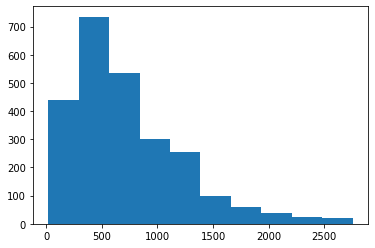

In [26]:
# Criando um histograma com todas elas
matplotlib.pyplot.hist(y_pred)

print('Histograma gerado com sucesso!!')

<h1 style="color:red;">PERGUNTA 4: PREVISÕES DO MODELO</h1>

**Analise as previsões do modelo. A distribuição dos dados previstos coincide com a distribuição dos dados reais? Que outras *features*/estratégias poderíamos usar para aprimorar ainda mais nosso modelo se tivéssemos mais tempo?**

*Escreva aqui sua resposta...*

# Importância das *features*

In [27]:
feature_importances(model, feature_matrix.columns, n=25)

1: Feature: trip_distance, 0.860
2: Feature: HOUR(pickup_datetime), 0.028
3: Feature: dropoff_neighborhoods.longitude, 0.027
4: Feature: dropoff_neighborhoods.latitude, 0.021
5: Feature: HOUR(dropoff_datetime), 0.012
6: Feature: MINUTE(dropoff_datetime), 0.007
7: Feature: MINUTE(pickup_datetime), 0.006
8: Feature: pickup_neighborhoods.latitude, 0.003
9: Feature: pickup_neighborhoods.SUM(trips.trip_distance), 0.003
10: Feature: dropoff_neighborhoods.COUNT(trips), 0.003
11: Feature: pickup_neighborhoods.longitude, 0.003
12: Feature: pickup_neighborhoods.COUNT(trips), 0.003
13: Feature: pickup_neighborhoods.MEDIAN(trips.trip_distance), 0.002
14: Feature: dropoff_neighborhoods.SUM(trips.trip_distance), 0.002
15: Feature: pickup_neighborhoods.MEAN(trips.trip_distance), 0.002
16: Feature: payment_type, 0.001
17: Feature: dropoff_neighborhoods.SUM(trips.passenger_count), 0.001
18: Feature: pickup_neighborhoods.MEAN(trips.passenger_count), 0.001
19: Feature: pickup_neighborhoods.STD(trips.trip

<h1 style="color:red;">PERGUNTA 5: IMPORTÂNCIA DAS FEATURES</h1>

**Analise a importância das *features* que você acabou de calcular. Elas fazem sentido? Algum valor te surpreendeu? Explique brevemente por que esses atributos são relevantes para o cálculo da variável de destino `trip_duration` (duração da corrida)**.

*Escreva aqui sua resposta...*

<hr>

Bom trabalho! Verifique a seção **Conclusão** do manual de instruções do estudo de caso.